# Exploratory Data Analysis (EDA)

The purpose of this notebook is to perform EDA on the cleaned data before modeling.

**Please note:** Because of the subject matter of this project, this notebook contains uncensored offensive language from the dataset.


In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import nltk
nltk.download('stopwords')
%matplotlib inline
plt.style.use('bmh')
# NLP libraries
import nltk
from sklearn.feature_extraction import text 
from nltk.stem import WordNetLemmatizer 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.naive_bayes import MultinomialNB

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [38]:
pip install stylecloud

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 262.1/262.1 KB 6.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.4/161.4 KB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 KB 11.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.8/87.8 KB 11.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for stylecloud: filename=stylecloud-0.5.2-py3-none-any.whl size=259510 sha256=c8bd225be00920c3f90b7c8e8c7ccfd60e865114295a476be0c9a22222b8d7b3
  Stored in directory: /root/.cache/pip/wheels/89/52/2d/2c5a52800b7bf64bb3c6cf3b59ffab9ad48ef373fcde0a0751
  Created wheel for fire: filename=fire-0.5.0-py2.py3-none-any.whl size=116949 sha256=de7ac0ca9da6bd21bb7f095d5aaa060131b274e03e54e9118fad4e84ffb59fc8
  Stored in directory: /root/.cache/p

In [39]:
import stylecloud

In [13]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [3]:
# loading in clean_df
from google.colab import files
data_to_load = files.upload()
import io
clean_df = pd.read_pickle(io.BytesIO(data_to_load['clean_df.pkl']))


Saving clean_df.pkl to clean_df (1).pkl


In [ ]:
# for local runtime
# clean_df = pd.read_pickle('clean_df.pkl')

In [4]:
clean_df.head(3)

,total_votes,hate_speech_votes,other_votes,label,tweet,clean_tweets
0,3,0,3,0,!!! RT @mayasolovely: As a woman you shouldn't...,as a woman you shouldnt complain about clea...
1,3,0,3,0,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,boy dats coldtyga dwn bad for cuffin dat ho...
2,3,0,3,0,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,dawg you ever fuck a bitch and she sta to...


We already know that the vocabulary for this dataset is **20277 unique words.**

# Censoring Words

In [5]:
replacements = { 'bitch':'b**ch', 'bitches':'b**ches', 'nigga':'n***a', 'nigger':'ni**er', 'ass':'a**', 'hoe':'h**', 'hoes':'h**s', 'faggot':'fa***t', 'faggots':'fa***ts', 'fuck':'f**k','fucking':'f**king', 'pussy':'p**sy', 'fag':'f**', 'shit':'sh*t' }

for k, v in replacements.items():
    clean_df['clean_tweets'] = clean_df['clean_tweets'].str.replace(k, v)

In [6]:
# checking that worked
clean_df.head(3)

,total_votes,hate_speech_votes,other_votes,label,tweet,clean_tweets
0,3,0,3,0,!!! RT @mayasolovely: As a woman you shouldn't...,as a woman you shouldnt complain about clea...
1,3,0,3,0,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,boy dats coldtyga dwn bad for cuffin dat h*...
2,3,0,3,0,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,dawg you ever f**k a b**ch and she sta to...


## Most Frequent Words for Each Classification

In [7]:
# creating new dfs for each classification
df_freq_hate = clean_df[clean_df['label']==1]
df_freq_not_hate = clean_df[clean_df['label']==0]

In [8]:
# pulling out the text data for cleaned tweets
data_hate = df_freq_hate['clean_tweets']
data_not_hate = df_freq_not_hate['clean_tweets']

In [11]:
# function to tokenize tweets and remove stop words with NLTK built-in library
stop_words = set(stopwords.words('english'))
def process_tweet(text):
    tokens = nltk.word_tokenize(text)
    stopwords_removed = [token.lower() for token in tokens if token.lower() not in stop_words]
    return stopwords_removed 

In [14]:
# creating lists for processed hate & not hate data
process_hate = list(map(process_tweet, data_hate))
process_not_hate = list(map(process_tweet, data_not_hate))

In [15]:
# exact amount of hate speech
total_vocab_hate = set()
for comment in process_hate:
    total_vocab_hate.update(comment)
len(total_vocab_hate)

3368

In [16]:
# exact amount of not hate speech
total_vocab_NOT_hate = set()
for comment in process_not_hate:
    total_vocab_NOT_hate.update(comment)
len(total_vocab_NOT_hate)

19452

## Most Common Words in Each Category

In [17]:
flat_hate = [item for sublist in process_hate for item in sublist]
flat_not_hate = [item for sublist in process_not_hate for item in sublist]

In [18]:
hate_freq = FreqDist(flat_hate)
not_hate_freq = FreqDist(flat_not_hate)

In [19]:
# Top 20 Hate Speech words:
hate_freq.most_common(20)

[('*', 3781),
 ('f', 371),
 ('b', 275),
 ('n', 255),
 ('fa', 240),
 ('ch', 209),
 ('ni', 167),
 ('like', 167),
 ('white', 126),
 ('k', 122),
 ('er', 112),
 ('trash', 112),
 ('u', 104),
 ('h', 101),
 ('king', 96),
 ('dont', 94),
 ('im', 93),
 ('get', 69),
 ('sh', 67),
 ('youre', 62)]

In [20]:
not_hate_freq.most_common(20)

[('*', 53313),
 ('b', 11269),
 ('ch', 8054),
 ('h', 4252),
 ('ches', 3032),
 ('like', 2601),
 ('f', 2513),
 ('n', 2398),
 ('p', 2111),
 ('sy', 2059),
 ('im', 1968),
 ('dont', 1657),
 ('got', 1540),
 ('get', 1359),
 ('k', 1342),
 ('sh', 1328),
 ('u', 1176),
 ('aint', 1128),
 ('trash', 1031),
 ('lol', 1025)]

## Normalizing Word Frequencies

In [21]:
hate_total_word_count = sum(hate_freq.values())
hate_top_25 = hate_freq.most_common(25)
print("Hate Word \t Normalized Frequency")
print()
for word in hate_top_25:
    normalized_frequency = word[1]/hate_total_word_count
    print("{} \t\t {:.4}".format(word[0], normalized_frequency))

Hate Word 	 Normalized Frequency

* 		 0.2462
f 		 0.02416
b 		 0.01791
n 		 0.0166
fa 		 0.01563
ch 		 0.01361
ni 		 0.01087
like 		 0.01087
white 		 0.008205
k 		 0.007944
er 		 0.007293
trash 		 0.007293
u 		 0.006772
h 		 0.006577
king 		 0.006251
dont 		 0.006121
im 		 0.006056
get 		 0.004493
sh 		 0.004363
youre 		 0.004037
people 		 0.003777
ches 		 0.003777
hate 		 0.003712
got 		 0.003712
ers 		 0.003581


In [22]:
not_hate_total_word_count = sum(not_hate_freq.values())
not_hate_top_25 = not_hate_freq.most_common(25)
print("Not Hate Word \t Normalized Frequency")
print()
for word in not_hate_top_25:
    normalized_frequency = word[1]/not_hate_total_word_count
    print("{} \t\t {:.4}".format(word[0], normalized_frequency))

Not Hate Word 	 Normalized Frequency

* 		 0.2185
b 		 0.0462
ch 		 0.03302
h 		 0.01743
ches 		 0.01243
like 		 0.01066
f 		 0.0103
n 		 0.00983
p 		 0.008654
sy 		 0.008441
im 		 0.008068
dont 		 0.006793
got 		 0.006313
get 		 0.005571
k 		 0.005501
sh 		 0.005444
u 		 0.004821
aint 		 0.004624
trash 		 0.004226
lol 		 0.004202
know 		 0.003152
love 		 0.002734
one 		 0.002718
cant 		 0.002591
na 		 0.002554


### Visualizing Top Word Percentages

In [23]:
# create counts of hate and not hate with values and words
hate_bar_counts = [x[1] for x in hate_freq.most_common(20)]
hate_bar_words = [x[0] for x in hate_freq.most_common(20)]

not_hate_bar_counts = [x[1] for x in not_hate_freq.most_common(20)]
not_hate_bar_words = [x[0] for x in not_hate_freq.most_common(20)]

In [24]:
# set the color of the bar graphs
color = cm.magma(np.linspace(.4,.8, 30))

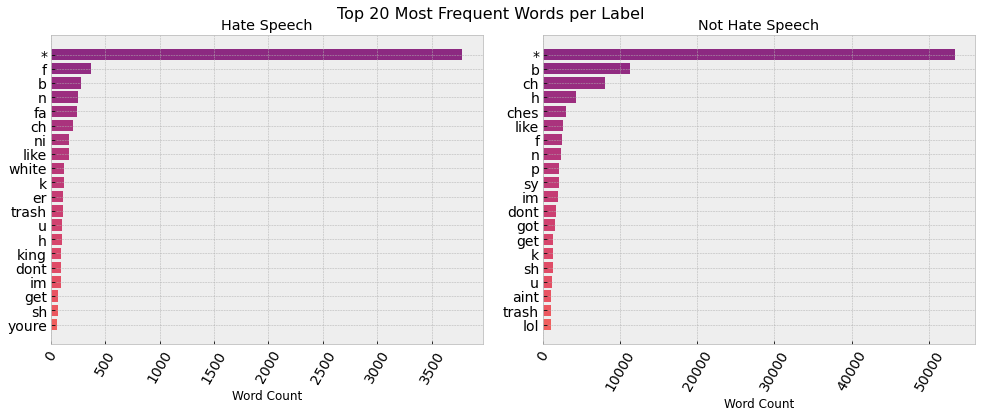

In [25]:
new_figure = plt.figure(figsize=(14,6))

ax = new_figure.add_subplot(121)
ax.invert_yaxis()

ax2 = new_figure.add_subplot(122)
ax2.invert_yaxis()

# generating a bar chart on each axes
ax.barh(hate_bar_words, hate_bar_counts, color=color)
ax2.barh(not_hate_bar_words, not_hate_bar_counts, color=color)

ax.title.set_text('Hate Speech')
ax2.title.set_text('Not Hate Speech')

for ax in new_figure.axes:
    plt.sca(ax)
    plt.xticks(rotation=60, fontsize=14)
    plt.xlabel("Word Count")
    plt.yticks(fontsize=14)
plt.tight_layout(pad=2)

new_figure.suptitle('Top 20 Most Frequent Words per Label', fontsize=16)

plt.savefig('/label_word_count_y.png', bbox_inches = "tight", pad_inches=.5)
plt.show()

Linguistically, it's important to note that the difference between hate speech and offensive lanugage often comes down to how it targets marginalized communities, often in threatening ways. 

For instance, we can notice from this figure that Hate Speech typically contains the N-word with the hard 'R'. The use of this slur indicates far more malicious intent, which goes beyond possibly using the word as slang.

Examples like that demonstratee the neuances of English slang and the fine line beteween Hate Speech and offensive language.

## What Words are Only in Hate Speech?

The purpose of this is to check whether the words unique to the "Hate Speech" label are threatening or especially derogatory.

In [26]:
def returnNotMatches(a, b):
    return [x for x in a if x not in b]

In [27]:
returnNotMatches(flat_hate, flat_not_hate)

['gaywad',
 'alsarabsss',
 'blacklisted',
 'xuccwoetmn',
 'ariza',
 'drakes',
 'nikejordan',
 'glitter',
 'qctplxhexm',
 'jackies',
 'stacey',
 'evaaaa',
 'ohiowhat',
 'photoshopped',
 'smmfhi',
 'aryan',
 'mongerls',
 'slum',
 'spicskkk',
 'deeeeaaaadd',
 'cheslook',
 'sixes',
 'noneuropeans',
 'farmers',
 'straightgt',
 'genetic',
 'engineering',
 'clones',
 'alls',
 'pontiac',
 'sprinkler',
 'naacp',
 'merely',
 'indicator',
 'wronggt',
 'indiviuals',
 'banner',
 'foolishness',
 'agg',
 'fkkk',
 'recruited',
 'buku',
 'warehouse',
 'gaywrites',
 'malt',
 'dammn',
 'potheads',
 'charging',
 'weirdos',
 'retweeettt',
 'chood',
 'happppppy',
 'bihdayyyy',
 'chuu',
 'baka',
 'lvndrdppqt',
 'pharrell',
 'zlpfzsitom',
 'bazinga',
 'aaaaaaaaand',
 'begins',
 'panthers',
 'hijack',
 'presser',
 'rhode',
 'peds',
 'roid',
 'causung',
 'mischief',
 'propery',
 'panthers',
 'nicely',
 'teammate',
 'zzzzzz',
 'yeawhat',
 'hypebeasts',
 'knockdowns',
 'coez',
 'brits',
 'itwas',
 'styl',
 'faaaa

As expected, a majority of these are racist, sexist and homophobic slurs that exceed cultural slang. The fact that these words are unique to the "Hate Speech" label affirm that it's indeed hate speech that should be flagged and taken down.

## Visualizing Unique Words with Venn Diagram

In [28]:
import matplotlib_venn as venn
from matplotlib_venn import venn2, venn2_circles, venn3, venn3_circles
import matplotlib.pyplot as plt

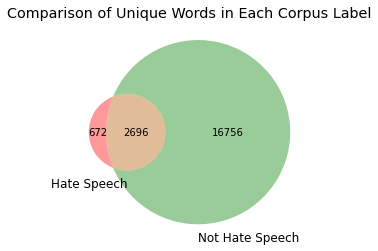

In [29]:
venn2([set(flat_hate), set(flat_not_hate)], set_labels = ('Hate Speech', 'Not Hate Speech'))
plt.title('Comparison of Unique Words in Each Corpus Label')
plt.savefig('/word_venn.png', bbox_inches = "tight", pad_inches=.5)

## Word Clouds

In [30]:
from wordcloud import WordCloud
hate_dict = dict(zip(hate_bar_words, hate_bar_counts))
not_hate_dict = dict(zip(not_hate_bar_words, not_hate_bar_counts))

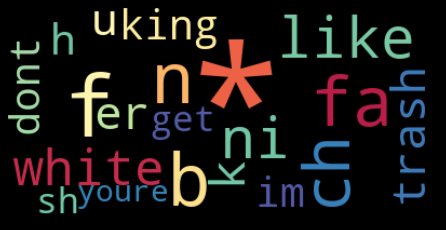

In [31]:
# create the word cloud:
wordcloud = WordCloud(colormap='Spectral').generate_from_frequencies(hate_dict)

# Display the generated image w/ matplotlib:
plt.figure(figsize=(6,6), facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)

# Uncomment the next line if you want to save your image:
# plt.savefig('satire_wordcloud.png')

plt.show()

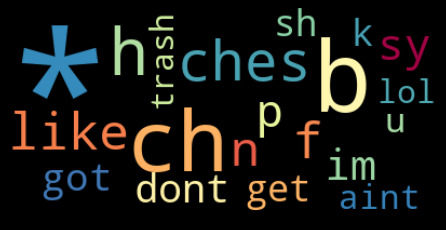

In [32]:
wordcloud = WordCloud(colormap='Spectral').generate_from_frequencies(not_hate_dict)

plt.figure(figsize=(6,6), facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
# plt.savefig('not_satire_wordcloud.png')

plt.show()

These word clouds are pretty much unusable on public-facing documents, but they tell us that the top words for each label are very similar. It may be hard for the models to differentiate beteween what can be classified as hate speech or not.

## Tweet Cloud of Most Frequent Words in Corpus

In [33]:
tweet_df = clean_df[['clean_tweets', 'label']].copy()

In [34]:
tweet_df.to_csv('/corpus.txt', sep='\t')

In [40]:
import stylecloud
stylecloud.gen_stylecloud(file_path = '/corpus.txt', icon_name= 'fab fa-twitter', collocations=False, output_name = "/icon_cloud.png")

![tweet_cloud](https://github.com/eba57/twitter_hate_speech_detection/blob/master/visualizations/icon_cloud.png?raw=1)

We can't really use this anywhere, but this was more just for fun :)

## CrowdFlower Votes

The first 3 columns of the dataframe indicate how many votes went into decided each label. Each tweet's label was decided by majority-rules. Let's see if we can pull any useful information from these columns.

In [41]:
clean_df.head(3)

,total_votes,hate_speech_votes,other_votes,label,tweet,clean_tweets
0,3,0,3,0,!!! RT @mayasolovely: As a woman you shouldn't...,as a woman you shouldnt complain about clea...
1,3,0,3,0,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,boy dats coldtyga dwn bad for cuffin dat h*...
2,3,0,3,0,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,dawg you ever f**k a b**ch and she sta to...


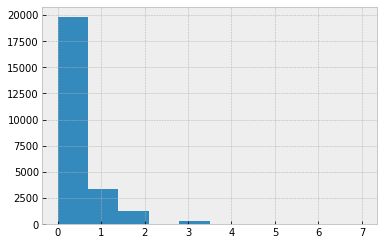

In [42]:
# distribution of vote counts for hate_speech_votes
clean_df.hate_speech_votes.hist()

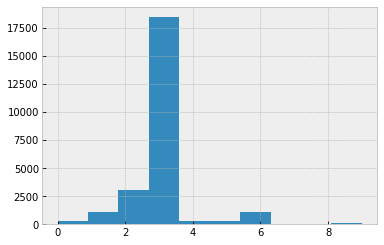

In [43]:
# distribution of vote counts for other_votes
clean_df.other_votes.hist()

### EDA on `total_votes` column

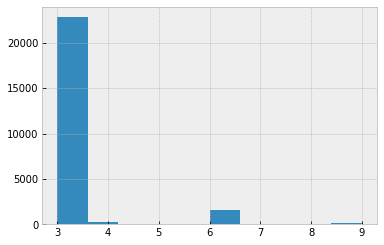

In [44]:
clean_df.total_votes.hist()